In [3072]:
%matplotlib inline
import re
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sbn
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

In [3073]:
all_courses = requests.get('https://www.luther.edu/catalog/curriculum')

In [3074]:
soup = BeautifulSoup(all_courses.text, 'html.parser')

In [3075]:
dept_list = soup.select('ul.childrenList a')
major_list = []
for item in dept_list:
    dept = item.get('href', 'None')
    if dept != 'None':
        major_list.append(dept)


In [3076]:
df = pd.DataFrame(columns=['Dept', 'CourseName', 'CourseNumber', 'Hours', 'GenEds', 'Prereqs', 'Description'])

In [3077]:
websites =[]
for item in major_list:
    x = 'https://www.luther.edu/catalog/curriculum/{}'.format(item)
    websites.append(x)


In [3078]:
def find_classes(my_soup,row):
    dept = my_soup.find_all('h1', class_='pageTitle')[0].text
    courses = my_soup.find_all('div', class_='courseContainer')
    for item in courses:
        course_title = item.find_all('span', class_='courseTitle')[0].text
        course_number = item.find_all('span', class_='courseNumber')[0].text
        credit_hours = item.find_all('li')[0].text
        for part in item.find_all('li'):
            if part.find_all('i', class_='fa-li fa fa-book fa-lg') != []:
                prereqs = part.text.split(' ')[1:]
                prereqs = ' '.join(prereqs)
            else:
                prereqs = ''
        description = item.find_all('span', class_='courseDescription')[0].text
        geneds = []
        for content in item.find_all('span', class_='genEd'):
            geneds.append(content.text)
        gened_string = ', '.join(geneds)
        df.loc[row] = [dept, course_title, course_number, credit_hours, gened_string, prereqs, description]
        row += 1
    return row

In [3079]:
row = 0
for item in major_list:
    this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
    soup = BeautifulSoup(this_course.text, 'html.parser')
    row = find_classes(soup, row)

In [3091]:
df.head()

Dept                    CourseName CourseNumber    Hours GenEds  \
0  Accounting    Introduction to Accounting    ACCTG 110  2 hours          
1  Accounting    Fundamentals of Accounting    ACCTG 150  4 hours          
2  Accounting  Managerial Cost Accounting I    ACCTG 250  4 hours          
3  Accounting     Intermediate Accounting I    ACCTG 353  4 hours          
4  Accounting    Intermediate Accounting II    ACCTG 354  4 hours          

                            Prereqs  \
0  First-year or sophomore standing   
1                         ACCTG 110   
2                         ACCTG 150   
3     ACCTG 250 and junior standing   
4                         ACCTG 353   

                                         Description  
0  A course specifically for students who have ha...  
1  The course provides a basic understanding of f...  
2  This course examines the central role of manag...  
3  Deals with financial accounting concepts and p...  
4  Further coverage of financial accounting conce...

In [3081]:
new_list = []
alist = []
import re
for item in df.Prereqs:
    new_list.append(re.findall(r'[A-Z][A-Z][A-Z]+', item))
for item in new_list:
    alist.append(item)
    
new_df = pd.DataFrame(columns= ['abbv', 'relations'])

new_df['abbv'] = df.CourseNumber.map(lambda x : x.split(' ')[0])

new_df['relations'] = alist

In [3082]:
s = new_df.relations.apply(pd.Series).stack().reset_index(level =1, drop=True)

s.name = 'relation'

new_df = new_df.drop('relations', axis=1).join(s)

new_df = new_df.reset_index(drop = True)

new_df = new_df.drop_duplicates()

new_df = new_df.reset_index(drop = True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

In [3083]:
#df.to_csv('allCourses.csv', index=False)

In [3084]:
#GRAPH WITH ONLY PRE-REQS DIRECTING TO ITS COURSE.
g = nx.DiGraph()
g.add_nodes_from(new_df.abbv)

for index, row in new_df.iterrows():
    g.add_edge(row['abbv'], row['relation'])

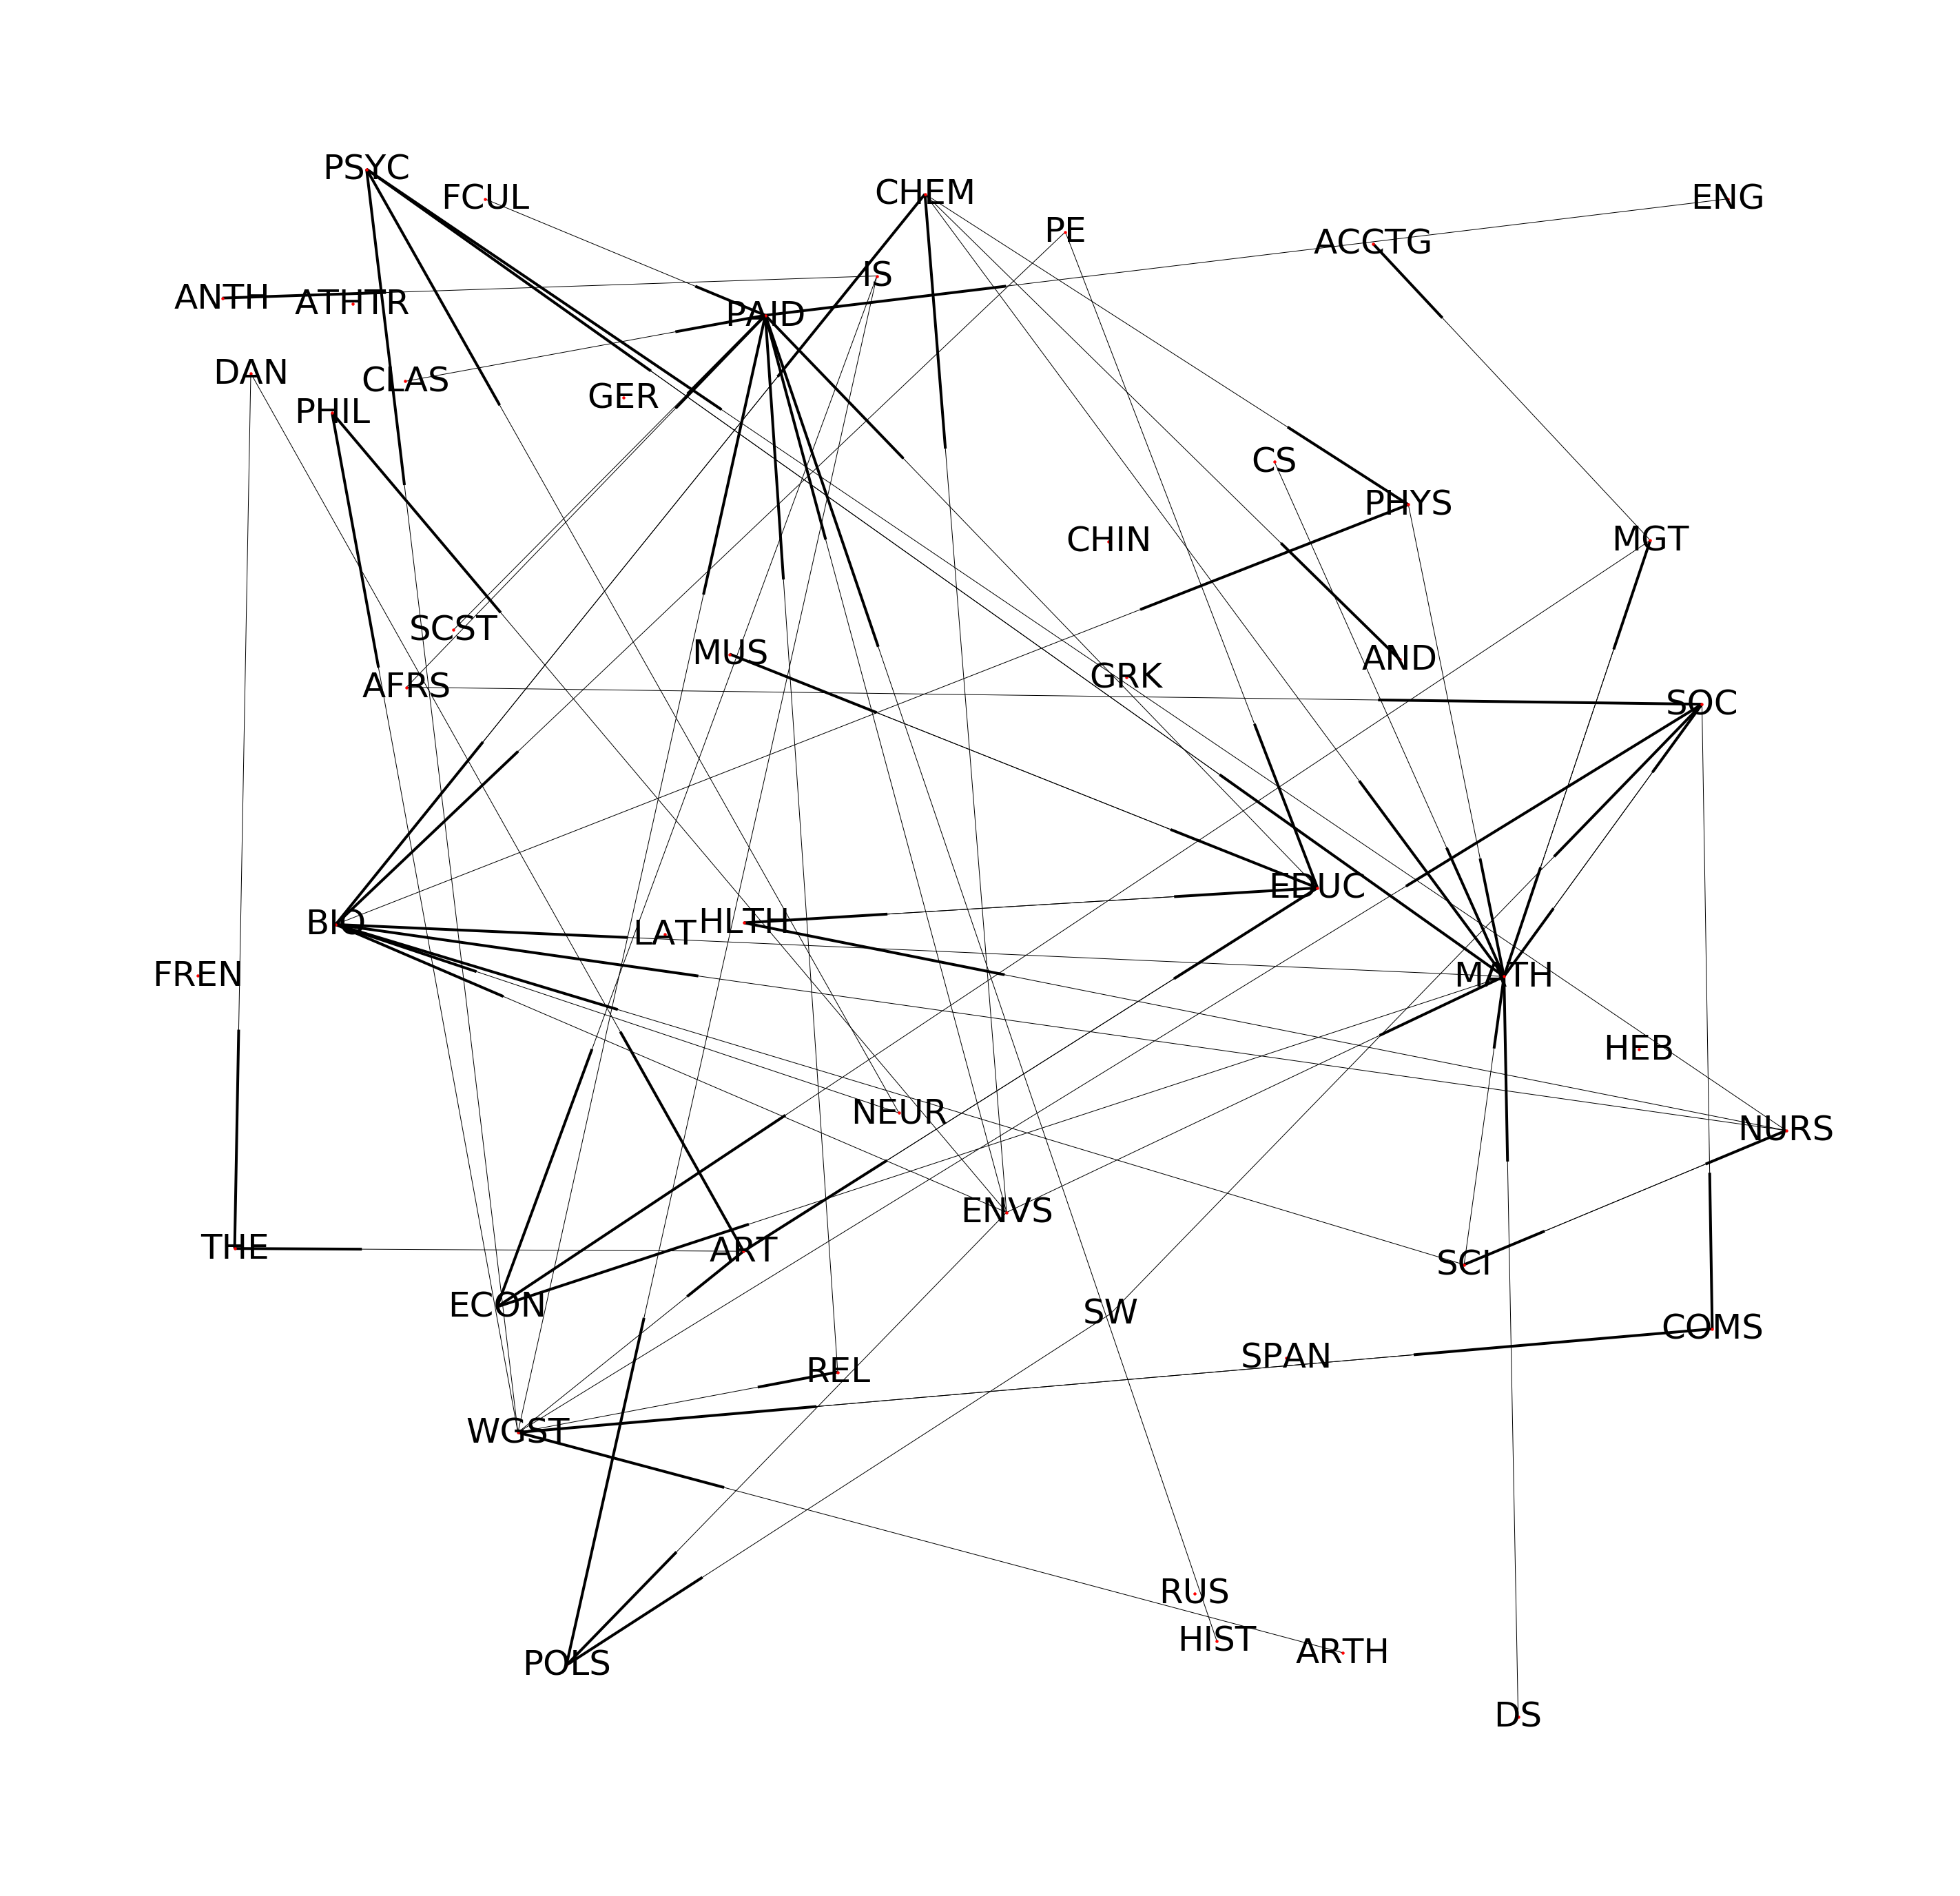

In [3085]:
gfig, gax = plt.subplots(figsize = (50,50))
nx.draw(g,nx.spring_layout(g, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 50, node_size = 15)

In [3086]:
try:
    for item in major_list:
        this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
        soup = BeautifulSoup(this_course.text, 'html.parser')
        list3 = []
        if soup.find_all('h1', class_='pageTitle')[0].text != 'Nordic Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Library and Information Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Biblical Languages' and soup.find_all('h1', class_='pageTitle')[0].text != 'International Business':
            this = soup.find_all('div', class_='catalog_block')
            #this = soup.find_all('a', name_='block2')
        #FIND BETTER WAY TO ABBV COURSE.
            that = soup.find_all('span', class_='courseNumber')[0].text
        else:
            pass
        for item in this:
            item = item.text
            list3.append(item)
        if len(that) > 1 :
            that = that.split(' ')
        that.pop()
        that = ''.join(that)
        list4 = []
        for item in list3:
            list4.append(re.findall(r'[A-Z][A-Z]+ [0-9]+', item))
        combining = [item for sublist in list4 for item in sublist]
        lst = []
        for item in combining:
            item = item.split(' ')
            lst.append(item)

        for item in lst:
            del item[1]
        lst = [item for sublist in lst for item in sublist]
        lst = set(lst)
        lst = list(lst)
        new_df.set_value(-1, 'abbv', that)
        new_df.set_value(-1, 'relation', lst)
        new_df = new_df.reset_index(drop=True)
except:
    print(item)
    


In [3087]:
s = new_df.relation.apply(pd.Series).stack().reset_index(level = 1, drop=True)

s.name = 'relations'

new_df = new_df.drop('relation', axis=1).join(s)

new_df = new_df.drop_duplicates()

new_df = new_df.sort_values(by=['abbv'])

new_df = new_df.replace('', np.nan, regex=True)

new_df = new_df.replace('^AND', np.nan, regex=True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

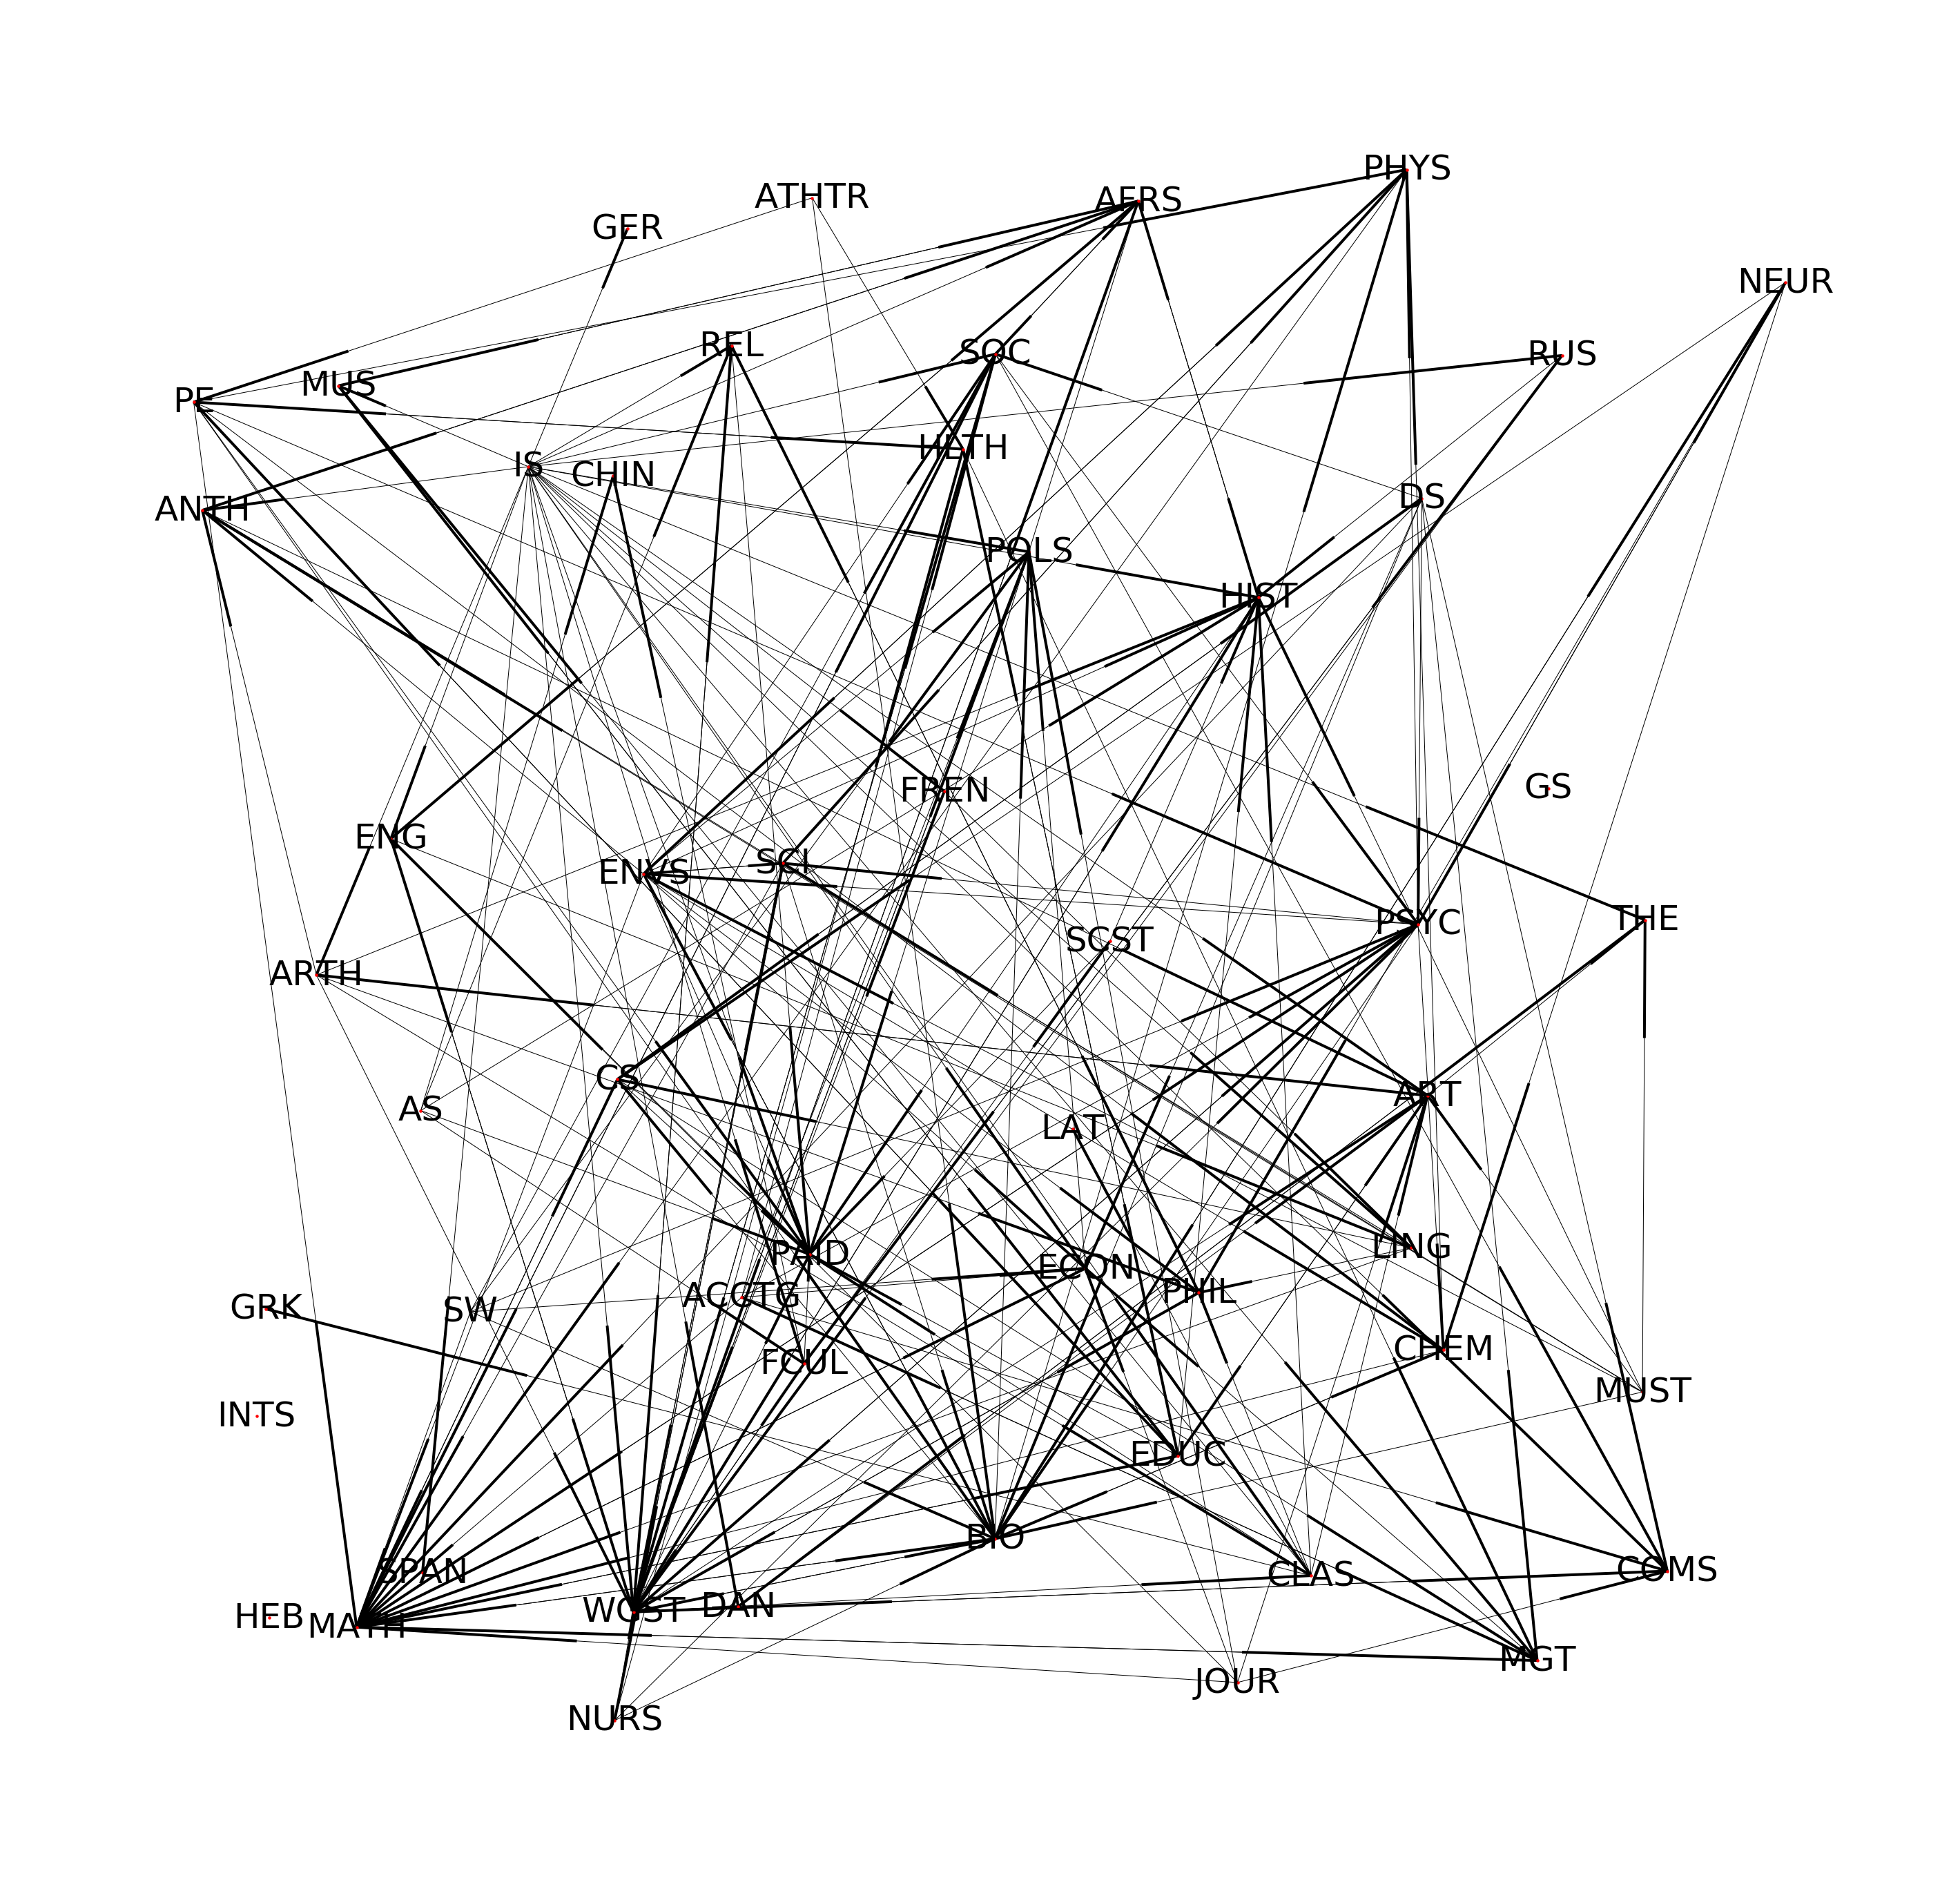

In [3088]:
g = nx.DiGraph()
g.add_nodes_from(new_df.abbv)


for index, row in new_df.iterrows():
    g.add_edge(row['abbv'], row['relations'])
        
gfig, gax = plt.subplots(figsize = (50,50))
nx.draw(g,nx.spring_layout(g, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 50, node_size = 15)

## WHICH COURSES ARE THE MOST NON-PREREQ/PRE-REQ IN OTHER COURSES.

In [3089]:
new_df.groupby('relations')['abbv'].count().head()

relations
ACCTG     2
AFRS      8
ANTH      7
ART      10
ARTH      3
Name: abbv, dtype: int64

In [3090]:
new_df.groupby('relations')['abbv'].count().head(15) > 10

relations
ACCTG    False
AFRS     False
ANTH     False
ART      False
ARTH     False
AS       False
ATHTR    False
BIO       True
CHEM     False
CHIN     False
CLAS     False
COMS     False
CS       False
DAN      False
DS       False
Name: abbv, dtype: bool